### Import and load data

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2022-10-08 23:05:40--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2022-10-08 23:05:40 (35.1 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


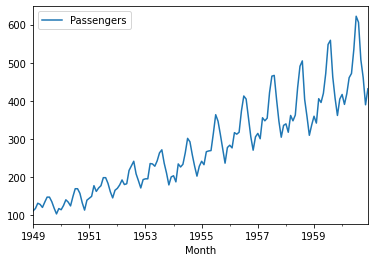

In [3]:
df = pd.read_csv("airline_passengers.csv", index_col="Month", parse_dates=True)
print(df.head())
df.plot();

### EWMA (Exponential Weighted Moving Average)

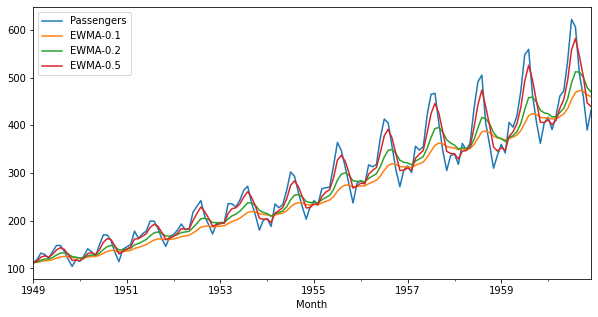

In [4]:
# Explore different values of alpha
df_ewma = df.copy()
df_ewma["EWMA-0.1"] = df_ewma["Passengers"].ewm(alpha=0.1, adjust=False).mean()
df_ewma["EWMA-0.2"] = df_ewma["Passengers"].ewm(alpha=0.2, adjust=False).mean()
df_ewma["EWMA-0.5"] = df_ewma["Passengers"].ewm(alpha=0.5, adjust=False).mean()
df_ewma.plot(figsize=(10,5));

In [5]:
# Add EWMA to df for alpha=0.2
alpha = 0.2
df["EWMA-0.2"] = df["Passengers"].ewm(alpha=alpha, adjust=False).mean()

### SES (Simple Exponential Smoothing)

In [6]:
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 27.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [7]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [8]:
# For our dataset, df.index.freq is None. The frequency is correctly inferred by pandas as monthly ("MS")
# and it is stored to df.index.inferred_freq.
# SimpleExpSmoothing gets the data frequency from df.index.freq if set. Otherwise, from df.index.inferred_freq.
# This generates a warning (we could avoid it by manually setting df.index.freq).
print(f"df.index.freq = {df.index.freq}")
print(f"df.index.inferred_freq = {df.index.inferred_freq}")

# API: initialize the model with the data, and specify hyperparameters during fit (opposite than sklearn).
# We set optimized=False to avoid a fit of alpha. For now, we want to use the same alpha as for EWMA.
ses = SimpleExpSmoothing(df["Passengers"], initialization_method="legacy-heuristic")
ses_res = ses.fit(alpha, optimized=False)

df.index.freq = None
df.index.inferred_freq = MS


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


True


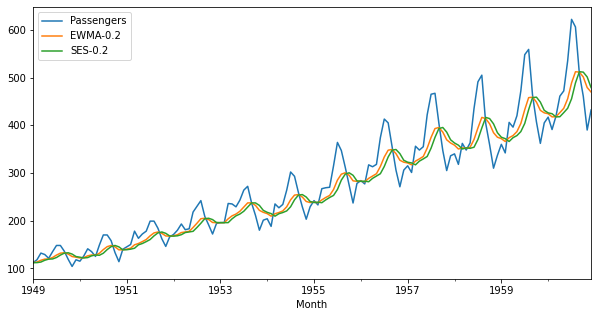

In [9]:
# To check against EWMA, we apply the model to the train set itself.
# We can use the predict method, or directly refer to fittedvalues, stored in the result object.
print(np.allclose(ses_res.fittedvalues, ses_res.predict(start=df.index[0], end=df.index[-1])))
df["SES-0.2"] = ses_res.fittedvalues
df.plot(figsize=(10,5));

In [10]:
# SES lags behind one step with respect to EWMA, because it is a t|t-1 prediction:
# the SES prediction at time t is the EWMA at t-1, by definition.
print(np.allclose(df["EWMA-0.2"].shift(1).iloc[1:], df["SES-0.2"].iloc[1:]))
df.head()

True


,Passengers,EWMA-0.2,SES-0.2
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


N_test = 14
alpha = 0.9999999850988388
True


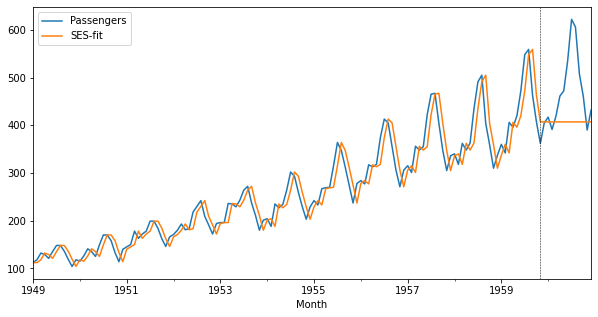

In [25]:
# Instead of specifying alpha, we optimize it by minimizing the squared error over the train set.
# We need to split the dataset into train and test.
test_size = 0.1
N_test = int(len(df) * test_size)
print(f"N_test = {N_test}")
df_train = df["Passengers"].iloc[:-N_test]
df_train.index.freq = df_train.index.inferred_freq  # to avoid SES warning
ses = SimpleExpSmoothing(df_train, initialization_method="legacy-heuristic")
# Fit
ses_res = ses.fit()  # no alpha specified, and optimized=True (default)
print(f"alpha = {ses_res.params['smoothing_level']}")
# Use fittedvalues for train set, and forecast for test set
df["SES-fit"] = pd.concat([ses_res.fittedvalues, ses_res.forecast(N_test)])
# Alternatively, we can use predict on all data
print(np.allclose(ses_res.predict(start=0, end=len(df)-1), df["SES-fit"]))
# Plot
df[['Passengers', 'SES-fit']].plot(figsize=(10,5));
plt.axvline(x=df.index[-N_test], color='black', ls='--', lw=.5);

N_test_2 = 17
alpha = 0.995


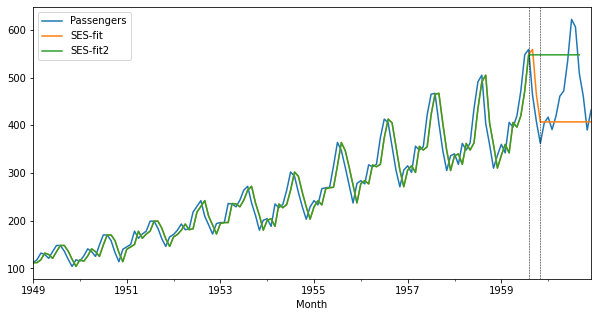

In [26]:
# Remarks: the SES model is too simple for the data, since it only estimates
# a level. Without trend nor seasonality, the best fit gives alpha=1, which
# corresponds to the naive forecast (using the previous value as best estimate).
# This is why the predictions for the train set are the series lagging by 1,
# and for the test set are set to the last seen observation (=train value).
# The naive forecast is obviously a bad model when the time series clearly
# displays a trend and a seasonality. The forecast changes completely if we
# change the test size and with it the last observation.
# We compare below the result with a slightly different test size
test_size_2 = 0.12
N_test2 = int(len(df) * test_size_2)
print(f"N_test_2 = {N_test2}")
df_train2 = df["Passengers"].iloc[:-N_test2]
df_train2.index.freq = df_train2.index.inferred_freq  # to avoid SES warning
ses2 = SimpleExpSmoothing(df_train2, initialization_method="legacy-heuristic")
# Fit
ses2_res = ses2.fit()
print(f"alpha = {ses2_res.params['smoothing_level']}")
# Plot
df2 = df.copy()
df2["SES-fit2"] = pd.concat([ses2_res.fittedvalues, ses2_res.forecast(N_test)])
df2[['Passengers', 'SES-fit', 'SES-fit2']].plot(figsize=(10,5));
plt.axvline(x=df.index[-N_test], color='black', ls='--', lw=.5);
plt.axvline(x=df.index[-N_test2], color='black', ls='--', lw=.5);

### Holt's linear trend

In [13]:
from statsmodels.tsa.holtwinters import Holt

N_test = 14
alpha = 0.9936
beta = 0.0018


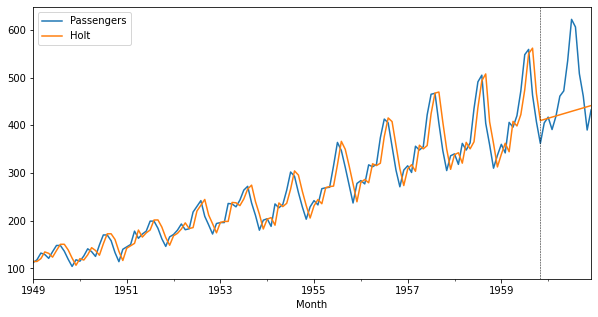

In [19]:
# We use a Holt model, that adds a trend to the fit.
test_size = 0.1
N_test = int(len(df) * test_size)
print(f"N_test = {N_test}")
df_train = df["Passengers"].iloc[:-N_test]
df_train.index.freq = df_train.index.inferred_freq 
holt = Holt(df_train, initialization_method="legacy-heuristic")
# Fit the hyperparameters to the train data
holt_res = holt.fit()
print(f"alpha = {holt_res.params['smoothing_level']:.4f}")
print(f"beta = {holt_res.params['smoothing_trend']:.4f}")
# Use fittedvalues for train set, and forecast for test set
df["Holt"] = pd.concat([holt_res.fittedvalues, holt_res.forecast(N_test)])
# Plot
df[['Passengers', 'Holt']].plot(figsize=(10,5));
plt.axvline(x=df.index[-N_test], color='black', ls='--', lw=.5);

N_test_2 = 17
alpha = 0.9950
beta = 0.0001


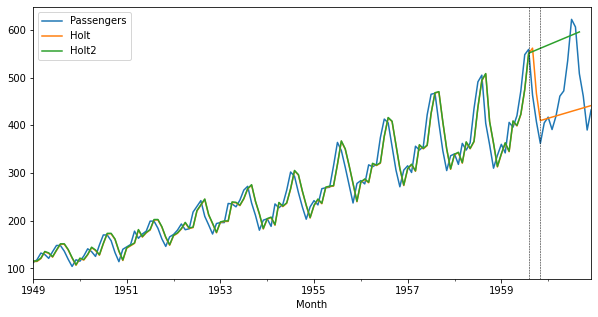

In [20]:
# Now we can see that the trend of the time series is captured.
# However, the same issue remains, that seasonality is not captured and
# the level depends strongly on the last observed train data point
# (and the forecast with it).
test_size_2 = 0.12
N_test2 = int(len(df) * test_size_2)
print(f"N_test_2 = {N_test2}")
df_train2 = df["Passengers"].iloc[:-N_test2]
df_train2.index.freq = df_train2.index.inferred_freq  # to avoid SES warning
holt2 = Holt(df_train2, initialization_method="legacy-heuristic")
# Fit
holt2_res = holt2.fit()
print(f"alpha = {holt2_res.params['smoothing_level']:.4f}")
print(f"beta = {holt2_res.params['smoothing_trend']:.4f}")
# Plot
df2 = df.copy()
df2["Holt2"] = pd.concat([holt2_res.fittedvalues, holt2_res.forecast(N_test)])
df2[['Passengers', 'Holt', 'Holt2']].plot(figsize=(10,5));
plt.axvline(x=df.index[-N_test], color='black', ls='--', lw=.5);
plt.axvline(x=df.index[-N_test2], color='black', ls='--', lw=.5);

### Holt-Winters

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [27]:
# We use the full Holt-Winters model, that also adds a seasonality term.
# We need to specify the seasonal periods (12 months), and how to combine the terms,
# if additively or multiplicatively.
test_size = 0.1
N_test = int(len(df) * test_size)
print(f"N_test = {N_test}")
df_train = df["Passengers"].iloc[:-N_test]
df_train.index.freq = df_train.index.inferred_freq
# From the plot it's clear that the amplitude of the oscillations increases over time,
# which speaks for a multiplicative form for the seasonal term.
# We try and compare 3 different choices: purely +, trend + & seasonal *, purely *.
seasonal_periods = 12
hw = {
  "aa": ExponentialSmoothing(df_train, initialization_method="legacy-heuristic",
          seasonal_periods=seasonal_periods, trend = "add", seasonal="add"),
  "am": ExponentialSmoothing(df_train, initialization_method="legacy-heuristic",
          seasonal_periods=seasonal_periods, trend = "add", seasonal="mul"),
  "mm": ExponentialSmoothing(df_train, initialization_method="legacy-heuristic",
          seasonal_periods=seasonal_periods, trend = "mul", seasonal="mul")
}
# Fit
hw_res = {name: model.fit() for name,model in hw.items()}
# Score on the train set
rmse = lambda y_pred, y: np.sqrt(np.mean((y - y_pred) ** 2))
mae = lambda y_pred, y: np.mean(np.abs(y - y_pred))
hw_train_scores = {name: {
    "RMES": rmse(res.fittedvalues, df_train),
    "MAE": mae(res.fittedvalues, df_train)} for name,res in hw_res.items()}
for name,scores in hw_train_scores.items():
  print(f"{name} train:", ", ".join([f"{measure} = {score:>5.2f}" for measure,score in scores.items()]))
# Score on the test set
df_test = df["Passengers"].iloc[N_test:]
hw_test_scores = {name: {
    "RMES": rmse(res.forecast(N_test), df_test),
    "MAE": mae(res.forecast(N_test), df_test)} for name,res in hw_res.items()}
for name,scores in hw_test_scores.items():
  print(f"{name} test :", ", ".join([f"{measure} = {score:>5.2f}" for measure,score in scores.items()]))

N_test = 14
aa train: RMES = 11.63, MAE =  9.00
am train: RMES =  9.65, MAE =  7.49
mm train: RMES =  9.58, MAE =  7.03
aa test : RMES = 18.49, MAE = 15.32
am test : RMES = 19.01, MAE = 17.47
mm test : RMES = 15.82, MAE = 11.55


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


alpha = 0.3561
beta  = 0.0000
gamma = 0.6278


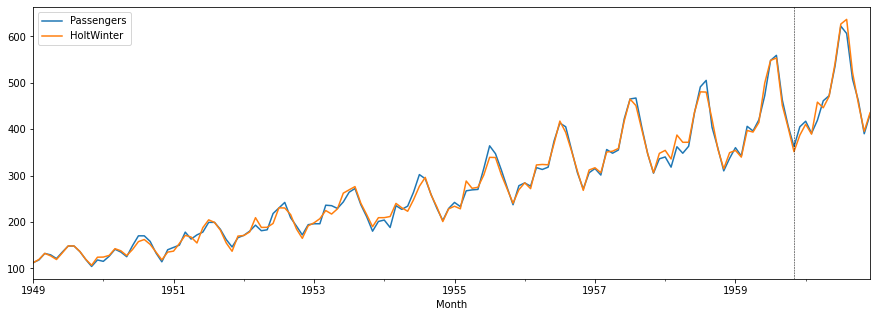

In [28]:
# The multiplicative model "mm" performs better. We select it and plot the predictions.
print(f"alpha = {hw_res['mm'].params['smoothing_level']:.4f}")
print(f"beta  = {hw_res['mm'].params['smoothing_trend']:.4f}")
print(f"gamma = {hw_res['mm'].params['smoothing_seasonal']:.4f}")
df["HoltWinter"] = pd.concat([hw_res["mm"].fittedvalues, hw_res["mm"].forecast(N_test)])
df[["Passengers", "HoltWinter"]].plot(figsize=(15,5));
plt.axvline(x=df.index[-N_test], color='black', ls='--', lw=.5);

N_test_2 = 17


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


alpha = 0.3964
beta  = 0.0000
gamma = 0.6036
train: RMES =  9.60, MAE =  7.07
test : RMES = 16.27, MAE = 14.58


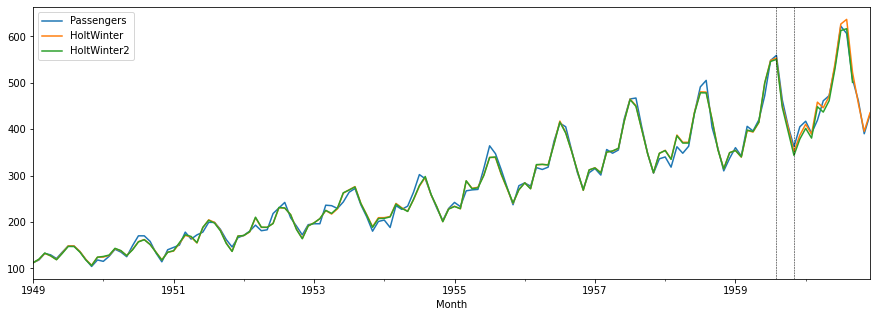

In [29]:
# This model, with a seasonal component, can clearly model the oscillations as well
# and it is not lagging behind anymore.
# We now check that choosing a different size for the test set (and therefore 
# the last train point observed) does not anymore affect the forecast significantly.
test_size_2 = 0.12
N_test2 = int(len(df) * test_size_2)
print(f"N_test_2 = {N_test2}")
df_train2 = df["Passengers"].iloc[:-N_test2]
df_train2.index.freq = df_train2.index.inferred_freq
hw2 = ExponentialSmoothing(df_train2, initialization_method="legacy-heuristic",
        seasonal_periods=seasonal_periods, trend = "mul", seasonal="mul")
# Fit
hw2_res = hw2.fit()
print(f"alpha = {hw2_res.params['smoothing_level']:.4f}")
print(f"beta  = {hw2_res.params['smoothing_trend']:.4f}")
print(f"gamma = {hw2_res.params['smoothing_seasonal']:.4f}")
# Score
df_test2 = df["Passengers"].iloc[N_test2:]
print(f"train: RMES = {rmse(hw2_res.fittedvalues, df_train2):>5.2f}, MAE = {mae(hw2_res.fittedvalues, df_train2):>5.2f}")
print(f"test : RMES = {rmse(hw2_res.forecast(N_test), df_test2):>5.2f}, MAE = {mae(hw2_res.forecast(N_test), df_test2):>5.2f}")
# Plot
df2 = df.copy()
df2["HoltWinter2"] = pd.concat([hw2_res.fittedvalues, hw2_res.forecast(N_test)])
df2[['Passengers', 'HoltWinter', 'HoltWinter2']].plot(figsize=(15,5));
plt.axvline(x=df.index[-N_test], color='black', ls='--', lw=.5);
plt.axvline(x=df.index[-N_test2], color='black', ls='--', lw=.5);